In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# General modules
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

# Project specific modules
from src.collision.fast_spec_col_2d import FastSpectralCollision2D
from src.solver import BC
from src.boltzmann_solver import BoltzmannSolver1D
from src.riemann.advection_1D import advection_1D
from src.solution import Solution
from src.utility import get_config

# Test 1: Vs. Euler with source term as limiting equation

We try to compare the Boltzmann solution with Euler equation with a source term:

\begin{align}
\left\{
\begin{aligned}
&\rho_t + \nabla_x(\rho u) = 0 \\
&(\rho u)_t + \nabla_x(\rho u\otimes u + p) = 0 \\
&E_t + \nabla_x (u(E+p)) = -\frac{1}{2}\rho^2 T
\end{aligned}
\right.
\end{align}

The initial condition is chosen as:

$$
(\rho, u, T) = (1+0.1\sin(6\pi x), 0, 1).
$$

In [2]:
from math import pi
def maxwellian_vectorized(v, u, T, rho):
    return rho[:,None,None]/(2*pi*T)*np.exp(-((v-u)[:,None]**2+v**2)/(2*T))

In [3]:
# Import config.json file
config_2d = get_config('./src/configs/config_1d_2d.json')
# Prepare collision
# config_2d.e = 1. - 1e-5
Q = FastSpectralCollision2D(config_2d)

In [4]:
Q.e

1

In [5]:
soln = Solution(config_2d)
x, v, _ = soln.c_centers
x, v = x[:,0,0], v[0,:,0]

## Initialize

Initial time: 0


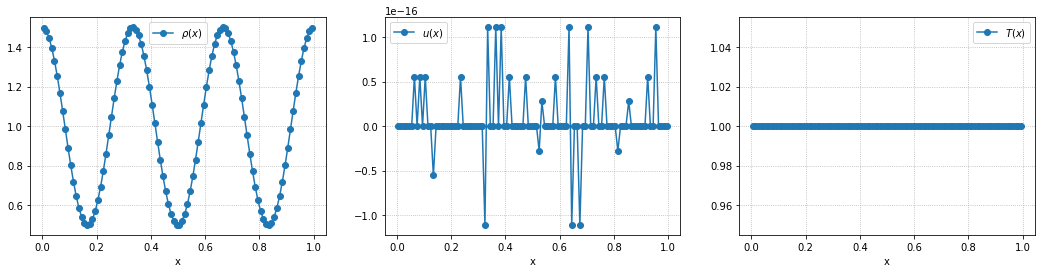

In [59]:
rho = 1. + 0.5*np.cos(6*pi*x)
f0 = np.empty(soln.f.shape)
f0 = maxwellian_vectorized(v, 0., 1., rho)

# Initialize
# with np.load('f_1e-5_new_32.npz') as data:
#     f0 = data['f']
    
soln.state.f = f0.copy()
soln.t = 0
# Plot
print("Initial time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(x, soln.rho, '-o', label=r'$\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'$u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'$T(x)$')
for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.set_xlabel
    iax.grid(which='both',linestyle=':')
    
# plt.savefig('ini_euler_6pi.pdf')

In [53]:
solver = BoltzmannSolver1D(1e-5)

solver.bc_lower[0] = BC.periodic
solver.bc_upper[0] = BC.periodic

solver.dt = 0.002
solver.time_integrator = 'TPI2'

solver.inner_steps = [3, 3, 3]
solver.inner_dt = [solver.kn, 10*solver.kn, 50*solver.kn]

solver.rp = advection_1D
solver.collision = Q.col_new
solver.order = 2

In [54]:
print("Initial time: {}; time step: {}".format(soln.t, solver.dt))
solver.evolve_to_time(soln, 0.1)

Initial time: 0; time step: 0.002


## Solution at $T = 0.1$:

Final time: 0.1


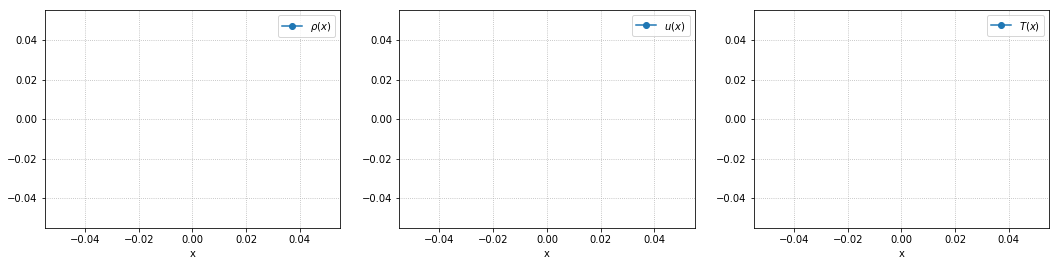

In [57]:
print("Final time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].plot(x, soln.rho, '-o', label=r'$\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'$u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'$T(x)$')
for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.grid(which='both',linestyle=':')

In [12]:
np.savez('f_1e-5_new_64_6pi.npz', f=soln.f, f0=f0)

## Clawpack Euler solver

In [69]:
from clawpack import pyclaw
from clawpack import riemann
from clawpack.riemann.euler_with_efix_1D_constants import *

gamma = 2.0 # Ratio of specific heats

def q_src(solver, state, dt):
    state.q[2] += 0.5*dt*(0.5*state.q[1]**2 - state.q[0]*state.q[2])
    
def dq_src(solver, state, dt):
    dq = np.zeros(state.q.shape)
    dq[2] = 0.5*dt*(0.5*state.q[1]**2 - state.q[0]*state.q[2])
    return dq
        
        
def setup(e=1, outdir='./_output', solver_type='sharpclaw',
          kernel_language='Python',disable_output=True):

    if kernel_language =='Python':
        rs = riemann.euler_1D_py.euler_hllc_1D
    elif kernel_language =='Fortran':
        rs = riemann.euler_with_efix_1D

    if solver_type=='sharpclaw':
        solver = pyclaw.SharpClawSolver1D(rs)
    elif solver_type=='classic':
        solver = pyclaw.ClawSolver1D(rs)

    solver.kernel_language = kernel_language
    solver.bc_lower[0]=pyclaw.BC.periodic
    solver.bc_upper[0]=pyclaw.BC.periodic
#     if e is not None:
#     solver.dq_src = dq_src


    mx = config_2d.nx
    x = pyclaw.Dimension(config_2d.xmin,config_2d.xmax,mx,name='x')
    domain = pyclaw.Domain([x])
    state = pyclaw.State(domain,num_eqn)

    state.problem_data['gamma'] = gamma
    state.problem_data['gamma1'] = gamma - 1.

    x = state.grid.x.centers
    
    T = 1.0
    state.q[density ,:] = rho
    state.q[momentum,:] = 0.
    state.q[energy  ,:] = rho*T

    claw = pyclaw.Controller()
    claw.tfinal = 1.0
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.num_output_times = 10
    claw.outdir = outdir
    claw.keep_copy = True
    if disable_output:
        claw.output_format = None

    return claw

In [68]:
claw = setup()
claw.run()

2019-04-26 10:37:06,846 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-26 10:37:06,947 INFO CLAW: Solution 1 computed for time t=0.100000
2019-04-26 10:37:07,018 INFO CLAW: Solution 2 computed for time t=0.200000
2019-04-26 10:37:07,095 INFO CLAW: Solution 3 computed for time t=0.300000
2019-04-26 10:37:07,173 INFO CLAW: Solution 4 computed for time t=0.400000
2019-04-26 10:37:07,235 INFO CLAW: Solution 5 computed for time t=0.500000
2019-04-26 10:37:07,320 INFO CLAW: Solution 6 computed for time t=0.600000
2019-04-26 10:37:07,382 INFO CLAW: Solution 7 computed for time t=0.700000
2019-04-26 10:37:07,435 INFO CLAW: Solution 8 computed for time t=0.800000
2019-04-26 10:37:07,504 INFO CLAW: Solution 9 computed for time t=0.900000
2019-04-26 10:37:07,557 INFO CLAW: Solution 10 computed for time t=1.000000


{'cflmax': 2.4852083389924027,
 'dtmin': 0.011081583448088964,
 'dtmax': 0.018503161105621047,
 'numsteps': 70}

In [70]:
claw1 = setup()
claw1.run()

2019-04-26 10:37:17,444 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-26 10:37:17,538 INFO CLAW: Solution 1 computed for time t=0.100000
2019-04-26 10:37:17,608 INFO CLAW: Solution 2 computed for time t=0.200000
2019-04-26 10:37:17,692 INFO CLAW: Solution 3 computed for time t=0.300000
2019-04-26 10:37:17,762 INFO CLAW: Solution 4 computed for time t=0.400000
2019-04-26 10:37:17,822 INFO CLAW: Solution 5 computed for time t=0.500000
2019-04-26 10:37:17,914 INFO CLAW: Solution 6 computed for time t=0.600000
2019-04-26 10:37:17,982 INFO CLAW: Solution 7 computed for time t=0.700000
2019-04-26 10:37:18,065 INFO CLAW: Solution 8 computed for time t=0.800000
2019-04-26 10:37:18,134 INFO CLAW: Solution 9 computed for time t=0.900000
2019-04-26 10:37:18,194 INFO CLAW: Solution 10 computed for time t=1.000000


{'cflmax': 2.492889896360457,
 'dtmin': 0.010731465071061345,
 'dtmax': 0.016019449552406254,
 'numsteps': 76}

Final time: 1.0


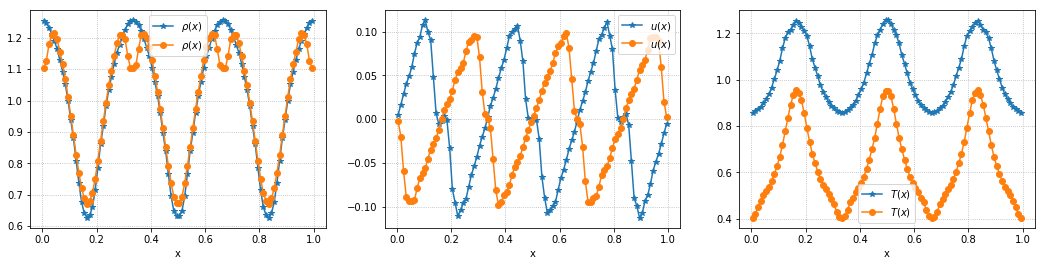

In [71]:
print("Final time: {}".format(claw.frames[-1].t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# ax[0].plot(x, claw.frames[-1].q[0], x, soln.rho, '-o', label=r'$\rho(x)$')
# ax[1].plot(x, claw.frames[-1].q[1]/claw.frames[-1].q[0], x, soln.u[0], '-o', label=r'$u(x)$')
# ax[2].plot(x, claw.frames[-1].q[2]/claw.frames[-1].q[0] - 0.5*(claw.frames[-1].q[1]/claw.frames[-1].q[0])**2, x, soln.T, '-o', label=r'$T(x)$')

ax[0].plot(x, claw1.frames[-1].q[0], '-*', label=r'$\rho(x)$')
ax[1].plot(x, claw1.frames[-1].q[1]/claw1.frames[-1].q[0], '-*', label=r'$u(x)$')
ax[2].plot(x, claw1.frames[-1].q[2]/claw1.frames[-1].q[0] - 0.5*(claw1.frames[-1].q[1]/claw1.frames[-1].q[0])**2, '-*', label=r'$T(x)$')

ax[0].plot(x, claw.frames[-1].q[0], '-o', label=r'$\rho(x)$')
ax[1].plot(x, claw.frames[-1].q[1]/claw.frames[-1].q[0], '-o', label=r'$u(x)$')
ax[2].plot(x, claw.frames[-1].q[2]/claw.frames[-1].q[0] - 0.5*(claw.frames[-1].q[1]/claw.frames[-1].q[0])**2, '-o', label=r'$T(x)$')


for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.grid(which='both',linestyle=':')

plt.savefig('e_pfe.pdf')

# Test 2: group

Considier the initial data as a Maxwellian with:

$$
(\rho, u, T) = (1 + 0.4\sigma, 0, 1),
$$

where $\sigma$ is a random variable with normal distribution:

$$
\sigma \sim \mathcal{N}(0, 0.1).
$$

We solve the inhomogeneous equation:

$$
\partial_t f + v\cdot\nabla f = Q_\text{in}(f, f),
$$

with $1$D in $x$ and $2$D in $v$.

In [3]:
from math import pi
def maxwellian_vectorized(v, u, T, rho):
    return rho[:,None,None]/(2*pi*T)*np.exp(-((v-u)[:,None]**2+v**2)/(2*T))

In [48]:
# Import config.json file
config_2d = get_config('./src/configs/config_1d_2d.json')
# config_2d.e = 1.0
# Prepare collision
# Q = FastSpectralCollision2D(config_2d)

In [49]:
soln = Solution(config_2d)
x, v, _ = soln.c_centers
x, v = x[:,0,0], v[0,:,0]

## Initialization and check

Initial time: 0


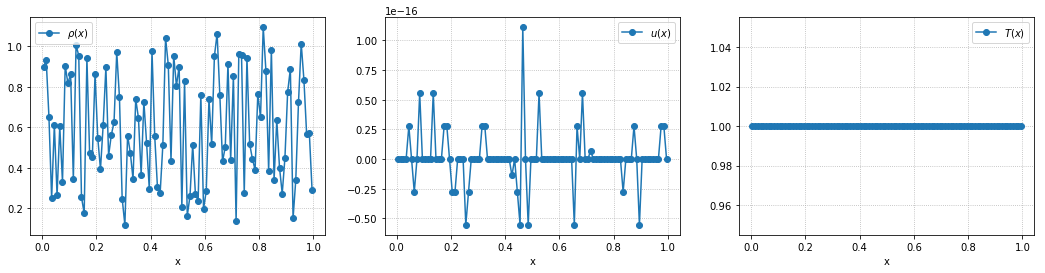

In [51]:
rho = 0.1 + np.random.uniform(0., 1, x.shape[0])
f0 = np.empty(soln.f.shape)
f0 = maxwellian_vectorized(v, 0., 1., rho)

#Initialize
soln.state.f = f0.copy()
soln.t = 0
# Plot
print("Initial time: {}".format(soln.t))
rho0 = soln.rho.copy()
u0 = soln.u[0].copy()
T0 = soln.T.copy()
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(x, rho0, '-o', label=r'$\rho(x)$')
ax[1].plot(x, u0, '-o', label=r'$u(x)$')
ax[2].plot(x, T0, '-o', label=r'$T(x)$')
for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.set_xlabel
    iax.grid(which='both',linestyle=':')

In [52]:
from clawpack import pyclaw
from clawpack import riemann
from clawpack.riemann.euler_with_efix_1D_constants import *

gamma = 2.0 # Ratio of specific heats

def q_src(solver, state, dt):
    state.q[2] += 0.5*dt*(0.5*state.q[1]**2 - state.q[0]*state.q[2])
    
def dq_src(solver, state, dt):
    dq = np.zeros(state.q.shape)
    dq[2] = 0.5*dt*(0.5*state.q[1]**2 - state.q[0]*state.q[2])
    return dq
        
        
def setup(e=1, outdir='./_output', solver_type='sharpclaw',
          kernel_language='Python',disable_output=True):

    if kernel_language =='Python':
        rs = riemann.euler_1D_py.euler_hllc_1D
    elif kernel_language =='Fortran':
        rs = riemann.euler_with_efix_1D

    if solver_type=='sharpclaw':
        solver = pyclaw.SharpClawSolver1D(rs)
    elif solver_type=='classic':
        solver = pyclaw.ClawSolver1D(rs)

    solver.kernel_language = kernel_language
    solver.bc_lower[0]=pyclaw.BC.periodic
    solver.bc_upper[0]=pyclaw.BC.periodic
#     if e is not None:
    solver.dq_src = dq_src


    mx = config_2d.nx
    x = pyclaw.Dimension(config_2d.xmin,config_2d.xmax,mx,name='x')
    domain = pyclaw.Domain([x])
    state = pyclaw.State(domain,num_eqn)

    state.problem_data['gamma'] = gamma
    state.problem_data['gamma1'] = gamma - 1.

    x = state.grid.x.centers
    
    state.q[density ,:] = rho0
    state.q[momentum,:] = rho0*u0
    state.q[energy  ,:] = rho0*T0

    claw = pyclaw.Controller()
    claw.tfinal = 1.0
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.num_output_times = 10
    claw.outdir = outdir
    claw.keep_copy = True
    if disable_output:
        claw.output_format = None

    return claw

In [53]:
claw = setup()
claw.run()

2019-04-29 14:58:04,967 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-29 14:58:05,068 INFO CLAW: Solution 1 computed for time t=0.100000
2019-04-29 14:58:05,154 INFO CLAW: Solution 2 computed for time t=0.200000
2019-04-29 14:58:05,215 INFO CLAW: Solution 3 computed for time t=0.300000
2019-04-29 14:58:05,284 INFO CLAW: Solution 4 computed for time t=0.400000
2019-04-29 14:58:05,345 INFO CLAW: Solution 5 computed for time t=0.500000
2019-04-29 14:58:05,414 INFO CLAW: Solution 6 computed for time t=0.600000
2019-04-29 14:58:05,474 INFO CLAW: Solution 7 computed for time t=0.700000
2019-04-29 14:58:05,535 INFO CLAW: Solution 8 computed for time t=0.800000
2019-04-29 14:58:05,612 INFO CLAW: Solution 9 computed for time t=0.900000
2019-04-29 14:58:05,680 INFO CLAW: Solution 10 computed for time t=1.000000


{'cflmax': 2.496364833589567,
 'dtmin': 0.011398173380490744,
 'dtmax': 0.017324116139071005,
 'numsteps': 72}

Final time: 1.0


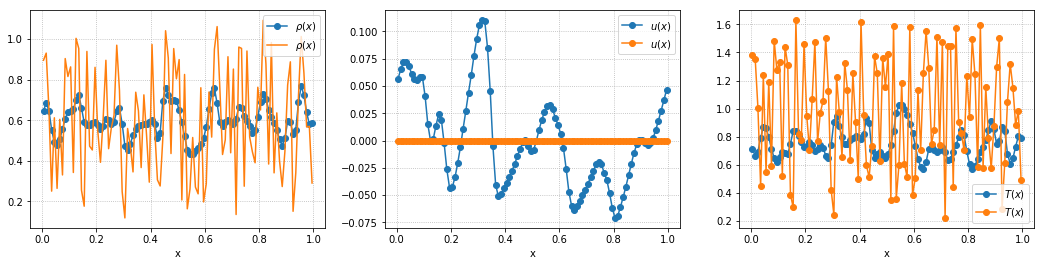

In [54]:
print("Final time: {}".format(claw.frames[-1].t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# ax[0].plot(x, claw.frames[-1].q[0], x, soln.rho, '-o', label=r'$\rho(x)$')
# ax[1].plot(x, claw.frames[-1].q[1]/claw.frames[-1].q[0], x, soln.u[0], '-o', label=r'$u(x)$')
# ax[2].plot(x, claw.frames[-1].q[2]/claw.frames[-1].q[0] - 0.5*(claw.frames[-1].q[1]/claw.frames[-1].q[0])**2, x, soln.T, '-o', label=r'$T(x)$')

# ax[0].plot(x, claw1.frames[-1].q[0], '-*', label=r'$\rho(x)$')
# ax[1].plot(x, claw1.frames[-1].q[1]/claw1.frames[-1].q[0], '-*', label=r'$u(x)$')
# ax[2].plot(x, claw1.frames[-1].q[2]/claw1.frames[-1].q[0] - 0.5*(claw1.frames[-1].q[1]/claw1.frames[-1].q[0])**2, '-*', label=r'$T(x)$')

ax[0].plot(x, claw.frames[-1].q[0], '-o', label=r'$\rho(x)$')
ax[1].plot(x, claw.frames[-1].q[1]/claw.frames[-1].q[0], '-o', label=r'$u(x)$')
ax[2].plot(x, claw.frames[-1].q[2]/claw.frames[-1].q[0] - 0.5*(claw.frames[-1].q[1]/claw.frames[-1].q[0])**2, '-o', label=r'$T(x)$')

ax[0].plot(x, claw.frames[0].q[0], '-', label=r'$\rho(x)$')
ax[1].plot(x, claw.frames[0].q[1]/claw.frames[-1].q[0], '-o', label=r'$u(x)$')
ax[2].plot(x, claw.frames[0].q[2]/claw.frames[-1].q[0] - 0.5*(claw.frames[-1].q[1]/claw.frames[-1].q[0])**2, '-o', label=r'$T(x)$')


for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.grid(which='both',linestyle=':')

# plt.savefig('e_pfe.pdf')

In [7]:
solver = BoltzmannSolver1D(0.1)

solver.bc_lower[0] = BC.periodic
solver.bc_upper[0] = BC.periodic

solver.dt = 0.0005
solver.time_integrator = 'Euler'
solver.inner_steps = [4, 4, 4]
solver.inner_dt = [solver.kn, 12*solver.kn, 80*solver.kn]

solver.rp = advection_1D
solver.collision = Q.col_new

In [8]:
print("Initial time: {}; time step: {}".format(soln.t, solver.dt))
import copy
from tqdm import tnrange
t = 0
T_list = []
for _ in tnrange(100):
    t += solver.dt
    solver.evolve_to_time(soln, t)
    T_list.append(np.mean(soln.T))

Initial time: 0; time step: 0.0005


KeyboardInterrupt: 

In [65]:
from scipy.optimize import curve_fit
time = np.linspace(0, 0.1, 100)
def temp(t, c):
    return 1 / (1 + c*t)**2

c, d = curve_fit(temp, time, np.array(T_list))

## Solution at $T = 0.2$:
$e = 0.8$

Final time: 0.20000000000000015


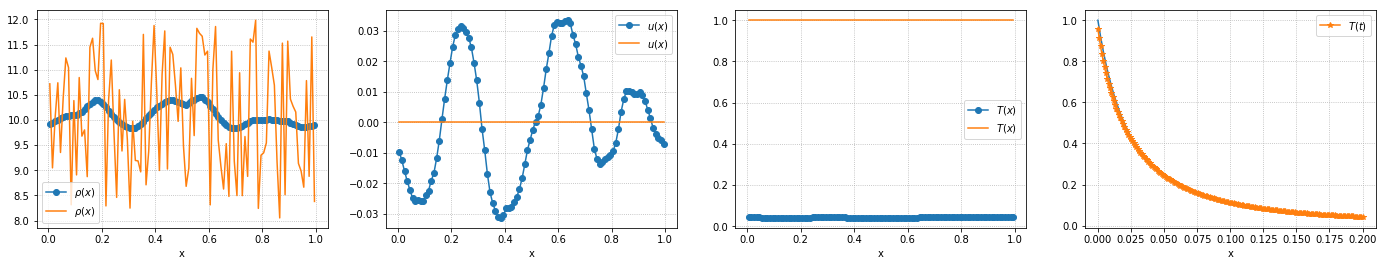

In [70]:
print("Final time: {}".format(soln.t))
fig, ax = plt.subplots(1, 4, figsize=(24, 4))
time = np.linspace(0, 0.2, 200)
ax[0].plot(x, soln.rho, '-o', label=r'$\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'$u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'$T(x)$')
ax[0].plot(x, rho0, label=r'$\rho(x)$')
ax[1].plot(x, u0, label=r'$u(x)$')
ax[2].plot(x, T0, label=r'$T(x)$')

ax[3].plot(time, temp(time, c))
ax[3].plot(time, T_list, '-*', label=r'$T(t)$')


for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.grid(which='both',linestyle=':')
# plt.savefig('noclustering.pdf')

$T=0.4$

Final time: 0.2


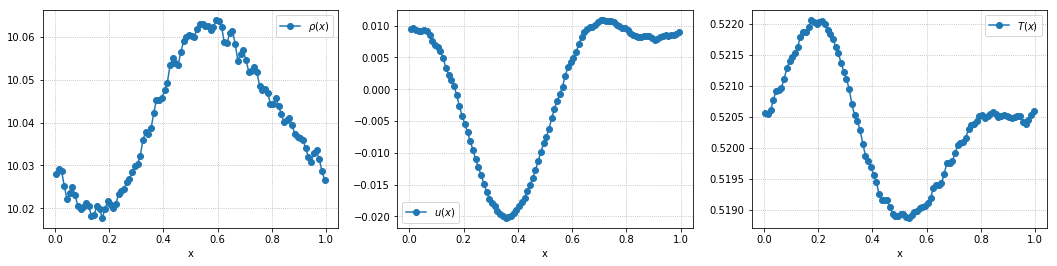

In [21]:
print("Final time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].plot(x, soln.rho, '-o', label=r'$\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'$u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'$T(x)$')
for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.grid(which='both',linestyle=':')

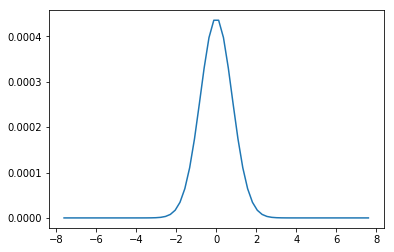

In [124]:
plt.plot(Q.v, soln.f[20, 20])

# *Solver validation*

We test the solver by setting $e = 1$ which fallback to the elastic case. This makes us to perform the Shock tube test.

The initial data are given by the Maxwellian distributions computed from the macroscopic quantities

\begin{align}
  (\rho_l, u_l, T_l) &= (1, 0, 0.5), \quad &\text{if } 0\leq x\leq 0.5, \\
  (\rho_r, u_r, T_r) &= (0.125, 0, 0.25) \quad &\text{if }0.5<x\leq 1.
\end{align}

Extrapolation boundary condition is applied.

In [17]:
# Import config.json file
config_2d = get_config('./src/configs/config_2D.json')
# Prepare collision
Q = FastSpectralCollision2D(config_2d)

In [18]:
from math import pi
def maxwellian(v, u, T, rho=1.0):
    return rho/(2*pi*T)*np.exp(-((v-u)[:,None]**2+v**2)/(2*T))

# Initialization and boundary conditions
func_l = lambda v: maxwellian(v, 0, 1.)
func_r = lambda v: maxwellian(v, 0, 0.25, 0.125)

In [19]:
soln = Solution(config_2d)
x, v, _ = soln.c_centers
x, v = x[:,0,0], v[0,:,0]

In [20]:
f0 = np.zeros(soln.f.shape)
f0[x<=.5] = func_l(v)*np.ones(x.shape)[x<=.5,None,None]
f0[x>.5] = func_r(v)*np.ones(x.shape)[x>.5,None,None]

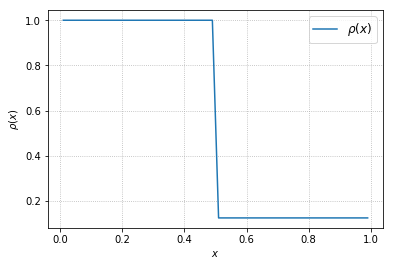

In [21]:
#Initialize
soln.state.f = f0.copy()
soln.t = 0
# Plot
fig, ax = plt.subplots()
ax.plot(x, soln.state.rho, label=r'$\rho(x)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')

In [22]:
solver = BoltzmannSolver1D(1e-4)

solver.bc_lower[0] = BC.extrap
solver.bc_upper[0] = BC.extrap

solver.dt = 0.002
solver.time_integrator = 'TPI3'
solver.inner_steps = [3, 3, 3]
solver.inner_dt = [1e-4, 3*1e-4, 6*1e-4]

solver.rp = advection_1D
solver.collision = Q.col_sep

In [ ]:
print("Initial time: {}; time step: {}".format(soln.t, solver.dt))
solver.evolve_to_time(soln, 0.1)

Final time: 0.1


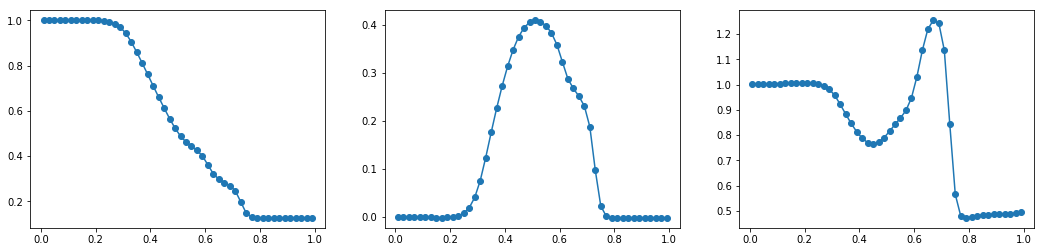

In [24]:
print("Final time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
# ax[0].plot(x, euler.state.rho, label=r'Euler: $\rho(x)$')
# ax[1].plot(x, euler.state.u[0], label=r'Euler: $u(x)$')
# ax[2].plot(x, euler.state.E/soln.state.rho - 0.5*euler.state.u[0]**2 - 0.5*euler.state.u[1]**2, label=r'Euler: $T(x)$')

ax[0].plot(x, soln.rho, '-o', label=r'PFE: $\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'PFE: $u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'PFE: $T(x)$')

## Save data

In [10]:
np.savez('./data_figs/e1.0kn-5_pfe.npz', soln.state.f)

In [15]:
euler = Solution(config_2d)
pfe = Solution(config_2d)
euler.state.f = np.load('./data_figs/e0.8kn-2_euler.npz')['arr_0']
pfe.state.f = np.load('./data_figs/e0.8kn-2_pfe.npz')['arr_0']

0.10000000000000007


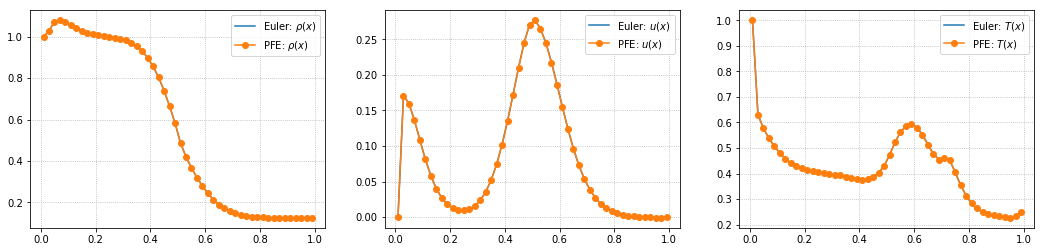

In [17]:
print(soln.state.t)
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(x, euler.state.rho, label=r'Euler: $\rho(x)$')
ax[1].plot(x, euler.state.u[0], label=r'Euler: $u(x)$')
ax[2].plot(x, euler.state.E/soln.state.rho - 0.5*euler.state.u[0]**2 - 0.5*euler.state.u[1]**2, label=r'Euler: $T(x)$')

ax[0].plot(x, pfe.state.rho, '-o', label=r'PFE: $\rho(x)$')
ax[1].plot(x, pfe.state.u[0], '-o', label=r'PFE: $u(x)$')
ax[2].plot(x, pfe.state.E/soln.state.rho - 0.5*pfe.state.u[0]**2 - 0.5*pfe.state.u[1]**2, '-o', label=r'PFE: $T(x)$')

for i in range(3):
    ax[i].legend()
    ax[i].grid(which='both',linestyle=':')
    
plt.savefig('./data_figs/e0.8kn-2.pdf')

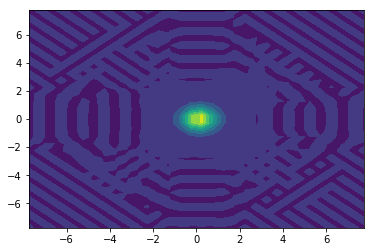

In [84]:
"""Plot the contour in velocity space for given index i"""
i = 28
fig, ax = plt.subplots()
cs = ax.contourf(euler.c_centers[-2][i], euler.c_centers[-1][i], euler.state.f[20])

# ax.clabel(cs, inline=0.5)
plt.savefig('./data_figs/e0.8kn-2_f.pdf')

In [75]:
rho_e_3 = np.copy(soln.state.rho)

0.1500000000000001


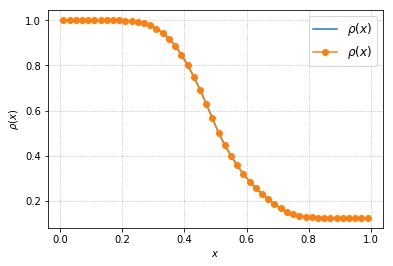

In [82]:
print(soln.state.t)
fig, ax = plt.subplots()
ax.plot(x, soln.state.rho, x, rho_e_3, 'o-', label=r'$\rho(x)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')